In [1]:
from pandas_datareader import data as web
import pandas as pd
import numpy as np
from sklearn import mixture as mix
import seaborn as sns
import matplotlib.pyplot as plt
import talib as ta
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import fix_yahoo_finance

In [2]:
#Fetching of data from yahoo finace
df = web.get_data_yahoo("SPY",start ="2000-01-01",end = "20-03-2018")

In [3]:
df.head(5)

,date,high,low,open,close,volume,adjclose
0,2018-03-20,271.670013,270.179993,270.940002,270.950012,59757300.0,270.950012
1,2018-03-19,274.399994,268.619995,273.350006,270.489990,109208400.0,270.489990
2,2018-03-16,275.390015,274.140015,274.500000,274.200012,100343700.0,274.200012
4,2018-03-15,276.609985,274.429993,275.880005,275.000000,83433000.0,273.902985
5,2018-03-14,278.019989,274.670013,277.809998,275.299988,105895100.0,274.201782


In [4]:
df = df[['open','high','low','close']]

In [5]:
n = 10 #Look back period of 10 days
t = 0.8 #splitting of data into 80:20
split = int(t * len(df)) #80% data for training and 20% data for testing

In [6]:
df['high'] = df['high'].shift(1) #shifted by 1,to access only past data
df['low'] = df['low'].shift(1) #shifted by 1,to access only past data
df['close'] = df['close'].shift(1) #shifted by 1,to access only past data
df['RSI'] = ta.RSI(np.array(df['close']),timeperiod = n) #Relative Strength Index
df['SMA'] = df['close'].rolling(window = n).mean() #simple moving average
df['corr'] = df['close'].rolling(window = n).corr(df['close'])#Correlation of data
df['SAR'] = ta.SAR(np.array(df['high']),np.array(df['low']),0.2,0.2)#Probalistic SAR to determing the furture short-term momentum
df['ADX'] = ta.ADX(np.array(df['high']),np.array(df['low']),np.array(df['close']),timeperiod = n) #Average Directional Index
df['Return'] = np.log(df['open']/df['open'].shift(1)) #Return of past day-1 on an open to open basis

In [7]:
df = df.dropna() #Droping NA values

In [8]:
df.head()

,open,high,low,close,RSI,SMA,corr,SAR,ADX,Return
21,272.029999,274.720001,269.940002,270.049988,45.656814,272.098996,1.0,277.064014,11.895043,0.000478
22,272.320007,273.670013,270.500000,271.399994,49.149356,271.950995,1.0,275.579214,10.758720,0.001066
23,271.570007,275.320007,272.269989,273.109985,53.367317,272.042993,1.0,269.640015,10.537421,-0.002758
24,264.309998,273.040009,268.769989,273.029999,53.138234,272.437994,1.0,275.320007,10.533801,-0.027097
25,263.970001,270.000000,264.299988,269.589996,44.093561,272.626993,1.0,275.320007,12.314819,-0.001287


In [9]:
ss = StandardScaler() #normalize the data by using standardization
#More information rgarding the model https://brilliant.org/wiki/gaussian-mixture-model/
unsup = mix.GaussianMixture(n_components=4,covariance_type="spherical",n_init=100,random_state=42)
unsup.fit(np.reshape(ss.fit_transform(df[:split]),(-1,df.shape[1])))#transformation of data
regime = unsup.predict(np.reshape(ss.fit_transform(df[split:]),(-1,df.shape[1]))) #predicted using unsupervised algorithm
Regimes = pd.DataFrame(regime,columns=['Regime'],index=df[split:].index).join(df[split:],how = 'inner').assign(market_cu_return = df[split:]
                               .Return.cumsum()).reset_index(drop=False).rename(columns ={'index':'Date'}) #save the prediction result

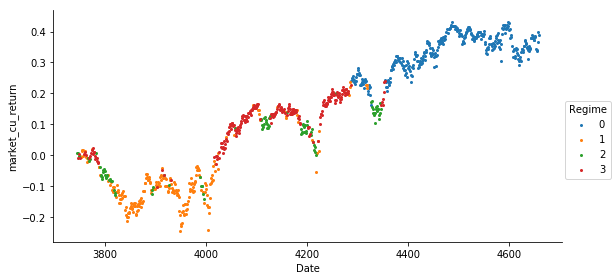

Mean of regime 0:  1.3237689530571084
Covariance for regim 0:  0.48085096144636064
Mean of regime 1:  -0.9995828346781248
Covariance for regim 1:  0.8920362453145858
Mean of regime 2:  -0.5353770744488126
Covariance for regim 2:  0.27157540222486526
Mean of regime 3:  -0.4524696346336615
Covariance for regim 3:  0.22484947147236886


In [10]:
#Graph of different Regimes of mean and variance
order = [0,1,2,3]
fig = sns.FacetGrid(data=Regimes,hue='Regime',hue_order=order,aspect=2,size=4)
fig.map(plt.scatter,'Date','market_cu_return',s=4).add_legend()
plt.show()
for i in order:
    print('Mean of regime %i: '%i,unsup.means_[i][0])
    print('Covariance for regim %i: '%i,(unsup.covariances_[i]))

In [11]:
#scaled the Regimes data frame, excluding the Date and Regimes columns, created in the earlier
ss1 = StandardScaler()
columns = Regimes.columns.drop(['Regime','Date'])
Regimes[columns] = ss1.fit_transform(Regimes[columns])
#signal column which would act as the prediction values
Regimes['Signal']=0 
Regimes.loc[Regimes['Return']>0,'Signal'] = 1
Regimes.loc[Regimes['Return']<0,'Signal'] = -1

In [12]:
#Support vector classifier and we do not optimized this support vector classifier for best hyper parameters.
cls = SVC(C= 1.0,cache_size=200,class_weight = None,coef0= 0.0,
           decision_function_shape=None,degree=3,gamma='auto',kernel='rbf',
           max_iter=-1,probability=False,random_state=None,shrinking=True,
           tol=0.001,verbose=False)

In [13]:
#split the test data of the unsupervised regime algorithm into train and test data
split2 = int(0.8*len(Regimes))
X = Regimes.drop(['Signal','Return','market_cu_return','Date'],axis =1)
y = Regimes['Signal']
cls.fit(X[:split2],y[:split2]) #fit the X and y data sets to the algorithm to train

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [14]:
# calculated the test set size and indexed the predictions
p_data = len(X)-split2

In [15]:
#based on these signals I calculated the returns of the strategy by multiplying signal at the beginning of the 
#day with the return at the opening ( because our returns are from open to open) of the next day.
df['Pred_signal'] = 0
df.iloc[-p_data:,df.columns.get_loc('Pred_signal')] = cls.predict(X[split2:])
print(df['Pred_signal'][-p_data:])
df['str_ret'] = df['Pred_signal'] * df['Return'].shift(-1)

4475    1
4477   -1
4479   -1
4480   -1
4481   -1
4482   -1
4483   -1
4484   -1
4485   -1
4486   -1
4487   -1
4488   -1
4489   -1
4490   -1
4491   -1
4492   -1
4493   -1
4494   -1
4495   -1
4496   -1
4497   -1
4498   -1
4499    1
4500   -1
4501   -1
4502    1
4503    1
4504    1
4505   -1
4506   -1
       ..
4629   -1
4630   -1
4631   -1
4632   -1
4633   -1
4634   -1
4635   -1
4636   -1
4637   -1
4638   -1
4639    1
4640    1
4641   -1
4642   -1
4643   -1
4644    1
4645   -1
4646   -1
4647   -1
4648   -1
4649   -1
4650   -1
4651   -1
4652   -1
4653   -1
4654   -1
4655    1
4656    1
4657    1
4658   -1
Name: Pred_signal, Length: 180, dtype: int64


In [16]:
#1.calculated the cumulative strategy returns and the cumulative market returns and saved them in df. 
#2.calculated the sharpe ratio to measure the performance.
df['strategy_cu_return'] = 0.0
df['market_cu_return'] = 0.0
df.iloc[-p_data:,df.columns.get_loc('strategy_cu_return')] = np.nancumsum(df['str_ret'][-p_data:])
df.iloc[-p_data:,df.columns.get_loc('market_cu_return')] = np.nancumsum(df['Return'][-p_data:])
Sharpe = (df['strategy_cu_return'].iloc[-1]-df['market_cu_return'].iloc[-1])/np.nanstd(df['strategy_cu_return'][-p_data:])

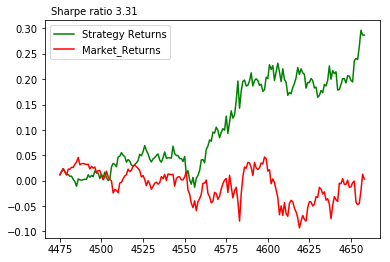

In [17]:
plt.plot(df['strategy_cu_return'][-p_data:],color='g',label='Strategy Returns')
plt.plot(df['market_cu_return'][-p_data:],color='r',label='Market_Returns')
plt.figtext(0.14,0.9,s='Sharpe ratio %.2f'%Sharpe)
plt.legend(loc='best')
plt.show()